In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.titleweight"] = "bold"
sns.set_style("whitegrid")
sns.set_palette("inferno")

In [2]:
colnames = ["Price", "Area", "Ownership", "NRooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Rent", "Garage", "BuildYear", "Lift", "City", "Longitude", "Latitude"]

In [3]:
df = pd.read_csv("otodom_krk_raw.csv", header=None, names=colnames)
df.head()

,Price,Area,Ownership,NRooms,Status,Floor,Balcony,Terrace,Garden,Rent,Garage,BuildYear,Lift,City,Longitude,Latitude
0,1250000,77.00,-1,3,-1,floor_no::floor_3,0,0,0,500,-1,2007,::n,krakow,19.941979,50.051057
1,932822,60.12,-1,3,construction_status::to_completion,floor_no::floor_1,0,0,1,-1,extras_types-85::garage,2024,::n,krakow,19.881340,50.016400
2,719000,39.00,-1,2,construction_status-67::ready_to_use,floor_no::ground_floor,0,0,0,500,-1,-1,::n,krakow,19.908257,50.020627
3,779000,50.47,-1,3,construction_status-67::ready_to_use,floor_no::floor_4,1,0,0,-1,extras_types-85::garage,1977,::y,krakow,19.927940,50.017480
4,-1,52.48,-1,2,construction_status::to_completion,floor_no::floor_2,1,0,1,-1,extras_types-85::garage,2025,::y,krakow,19.899965,50.084740


In [4]:
df = df.replace("-1", np.nan).replace(-1, np.nan)

# Missing values

The majority of missing values are in **Rent** column, which actually is not that important, so it is going to be dropped.<br>
In terms of the **Price** column - I am going to drop all the rows with missing values there, I don't want to add another noise to the dataset, especially when there is that many of them.<br>
Rows with missing **Balcony**, **Terrace**, **Lift**, **Garage** columns are just indicating that there is a lack of these features in the flat, so I am going to fill them with **0s**.<br>
Missing value for **Ownership** probably tells us that it was obvious for the seller that the ownership is full, so there was no need to state the other way, I am going to fill the missing values with **1s**. The same for **Status** column.<br>
**BuildYear's** missing values are going to be filled with grouped correlated values created by some sort of **Imputer**.

---

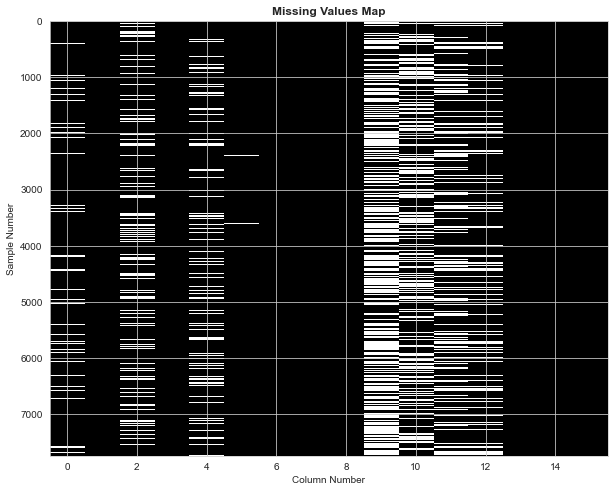

In [5]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");
plt.title("Missing Values Map", weight="bold")
plt.show()

### Rent column
---

In [6]:
df = df.drop("Rent", axis=1)

### Price column
---

In [7]:
df = df[~df["Price"].isna()]

### Lift column
---

In [8]:
df["Lift"] = df["Lift"].fillna("0").replace("::y", "1").replace("::n", "0")

### Garage column
---

In [9]:
df["Garage"] = df["Garage"].fillna("0").replace("extras_types-85::garage", "1")

### Ownership column
---

In [10]:
df["Ownership"] = df["Ownership"].fillna("1").apply(lambda x: "1" if x == "building_ownership::full_ownership" else "0")

### Status column
---

In [11]:
df["Status"] = df["Status"].fillna("1").apply(lambda x: "1" if x == "construction_status-67::ready_to_use" else "0")

### Floor column
---

In [12]:
def convert_floor(floor_string: str) -> str:
    try:
        res = floor_string[10:]
        if res in ["floor_10", "floor_higher_10", "garret"]:
            return "10"
        elif res == "ground_floor":
            return "0"
        else:
            return res[6:]
    except:
        return floor_string

In [13]:
df["Floor"] = df["Floor"][~df["Floor"].isin(["floor_no::cellar"])].apply(lambda x: convert_floor(x))

In [14]:
df = df[~df["Floor"].isna()]

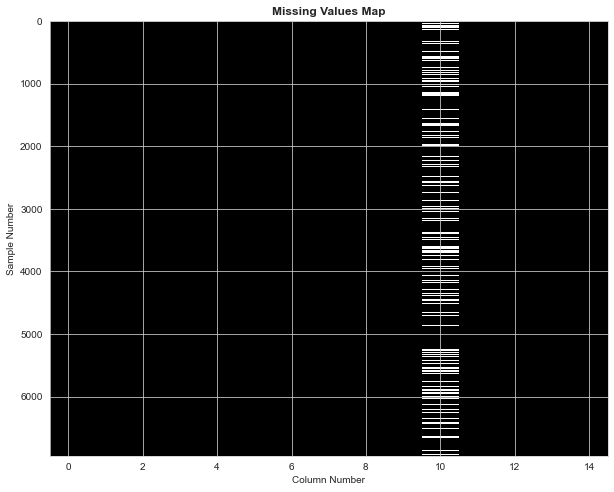

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");
plt.title("Missing Values Map", weight="bold")
plt.show()

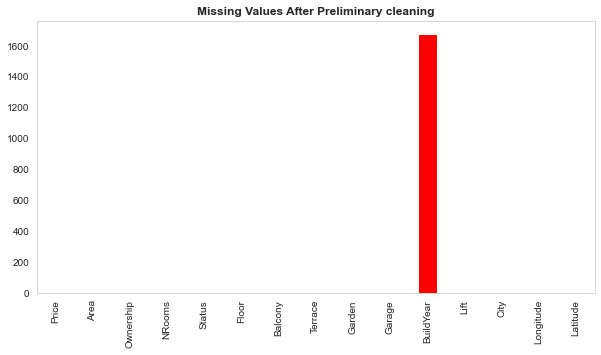

In [16]:
plt.figure(figsize=(10,5))
df.isna().sum().plot(kind="bar", color="red")
plt.title("Missing Values After Preliminary cleaning", weight="bold")
plt.grid()
plt.show()

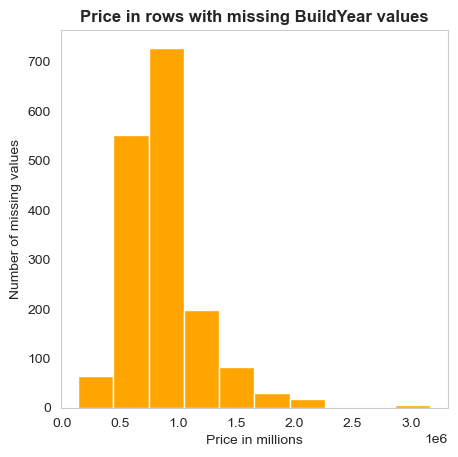

In [17]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

df[df["BuildYear"].isna()]["Price"].plot(kind="hist", ax=ax, color="orange")
ax.grid()
ax.set_xlabel("Price in millions")
ax.set_ylabel("Number of missing values")
ax.set_title("Price in rows with missing BuildYear values", weight="bold")
plt.show()

# Let's have a little insight on the data

Before I decide what to really do with **BuildYear** missing values, I need to see how the data looks like a little bit.

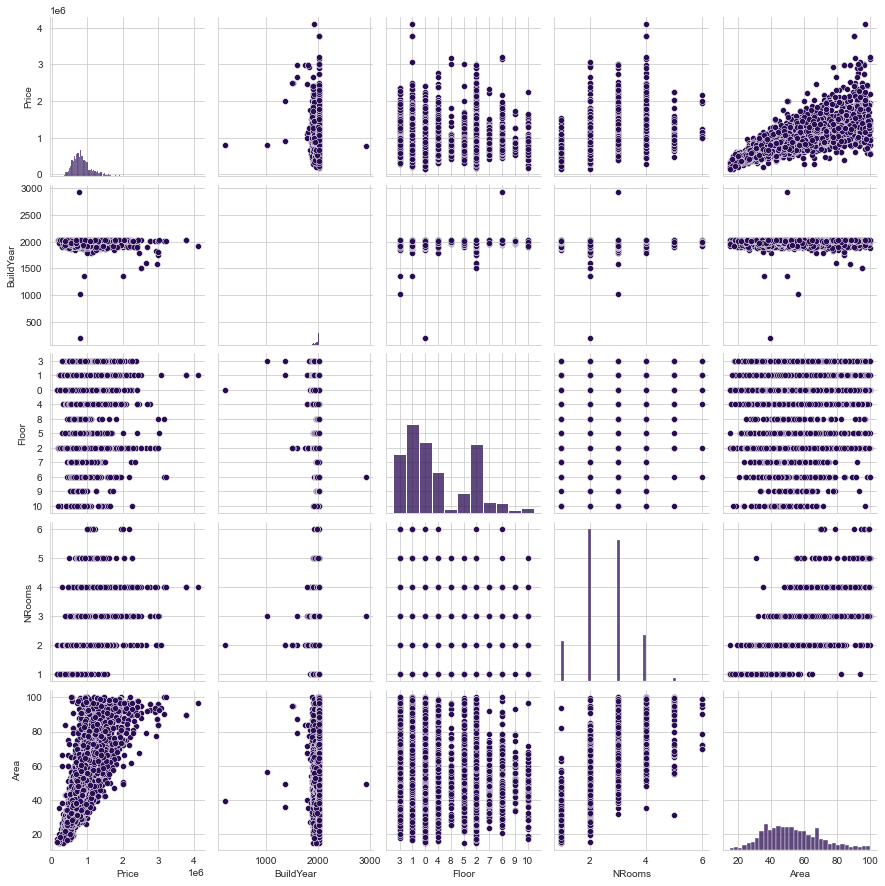

In [18]:
sns.pairplot(df, vars=["Price", "BuildYear", "Floor", "NRooms", "Area"])
plt.show()

# First steps
The key insights gathered from a simple visualization for each feature:<br>
- **Price**:<br>
&emsp; I need to take care of outliers, especially knowing that I want my model to be created for prices not higher than 1.5m, I should also check the lower values that are biased.
- **BuildYear**:<br>
&emsp; Apart from imputing missing data, I can see huge outliers in both directions, It would be probably a good choice to put the values into buckets rather than leave the years alone.
- **Floor**:<br>
&emsp; Higher floors are the minority in the dataset, I should probably put all of them into one bucket.
- **NRooms**:<br>
&emsp; There are only a few instances of flats with 5 or 6 rooms, I should think about the solution for this problem (bucketing or dropping)
- **Area**:<br>
&emsp; Area is filtered right-away by the site filters, however I need to fix the Area-NRooms correlation, where I can see interesting outliers.
---

## Price
---

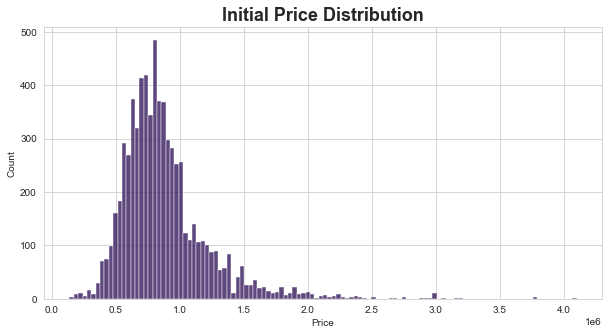

In [23]:
sns.histplot(data=df, x="Price")
plt.title("Initial Price Distribution", weight="bold", fontsize=18)
plt.show()

In [33]:
no_more_1500k = df[df["Price"] > 1500000]
no_less_150k  = df[df["Price"] < 150000]
print(f"There are {no_more_1500k.shape[0]} records with price higher than 1.5m")
print(f"There are {no_less_150k.shape[0]} records with price less than 150k")

There are 355 records with price higher than 1.5m
There are 3 records with price less than 150k


In [34]:
df = df[(df["Price"] >= 150000) & (df["Price"] <= 1500000)]

In [35]:
df.shape[0]

6586

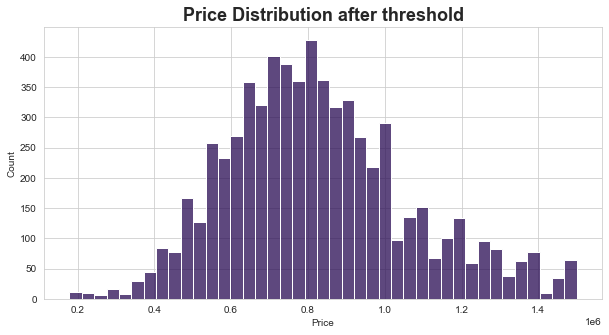

In [37]:
sns.histplot(data=df, x="Price")
plt.title("Price Distribution after threshold", weight="bold", fontsize=18)
plt.show()

## Floor
---

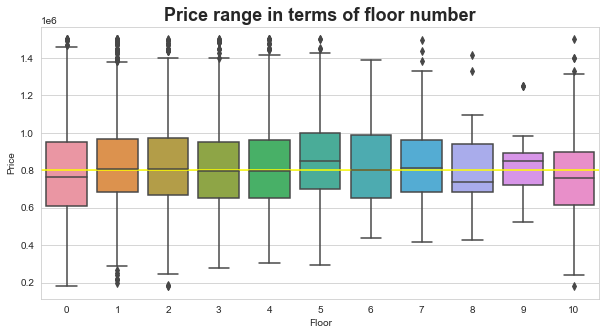

In [65]:
sns.boxplot(data=df, x="Floor", y="Price", order=sorted(df["Floor"].unique(), key=lambda x: int(x)))
plt.title("Price range in terms of floor number", weight="bold", fontsize=18)
plt.axhline(y=df["Price"].median(), color="yellow")
plt.show()

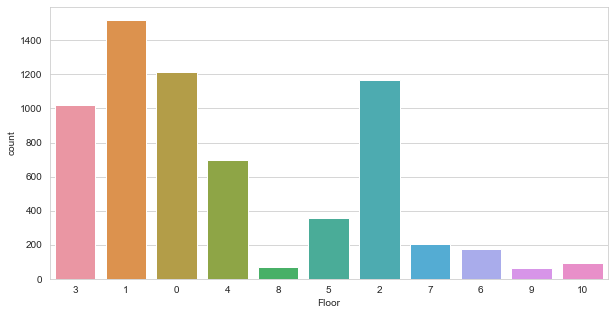

In [51]:
sns.countplot(data=df, x="Floor")
plt.show()

### NRooms
---

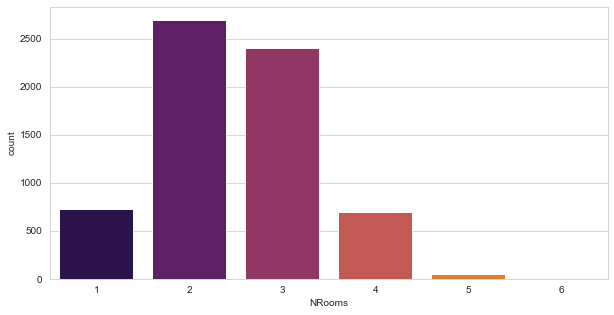

In [66]:
sns.countplot(data=df, x="NRooms")
plt.show()

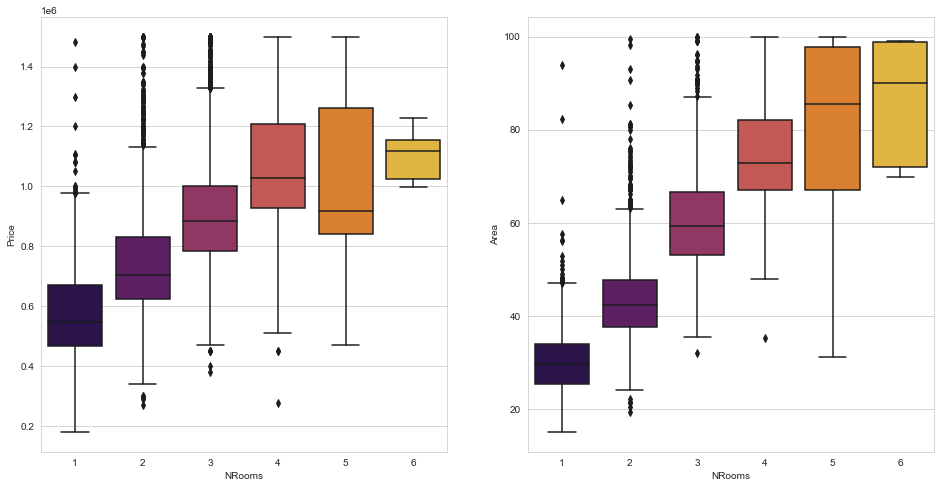

In [75]:
fig, axes = plt.subplots(figsize=(16, 8), ncols=2)

sns.boxplot(data=df, x="NRooms", y="Price", ax=axes[0])
sns.boxplot(data=df, x="NRooms", y="Area", ax=axes[1])
plt.show()

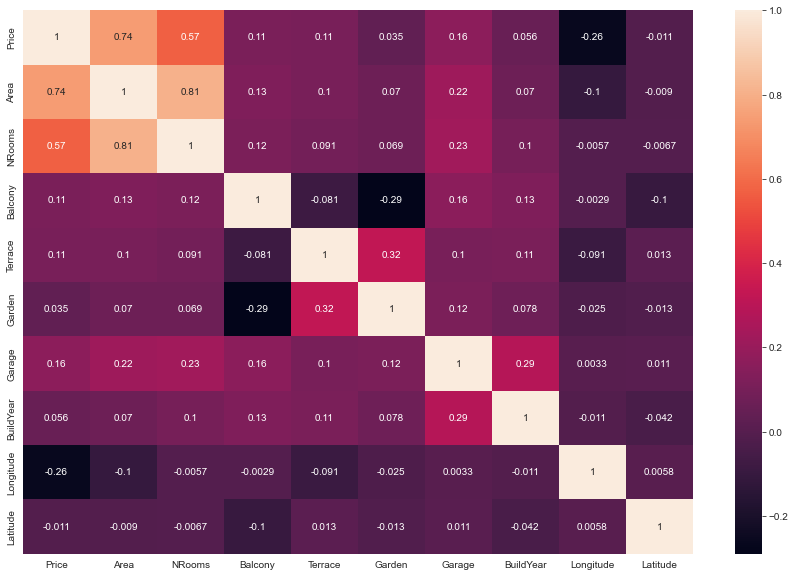

In [85]:
plt.figure(figsize=(15,10))
df["Garage"] = df["Garage"].astype("int")
sns.heatmap(df.corr(), annot=True)
plt.show()